In [3]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from collections import OrderedDict
import umap
from datetime import datetime, timedelta
from types import SimpleNamespace 
# Add parent path for import
import sys
sys.path.append("..")
from data.data_utils import *
from data.dataloader_detection import load_dataset_detection
from data.dataloader_classification import load_dataset_classification
import utils 
from model.model import NeuroGNN_Classification, DCRNNModel_classification
from constants import *
pd.set_option('display.max_columns', 50)
os.chdir(os.getcwd().split('NeuroGNN')[0] + 'NeuroGNN')
os.getcwd()
os.environ['$HDF5_USE_FILE_LOCKING'] = 'FALSE'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but

In [9]:
NEUROGNN_CLASSIFICATION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/neurognn/train/train-112'
NEUROGNN_CLASSIFICATION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/neurognn/train/train-127'
NEUROGNN_DETECTION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/neurognn/train/train-93'
NEUROGNN_DETECTION_PRETRAINED_BEST_THRES = 0.7361
NEUROGNN_DETECTION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/neurognn/train/train-82' 
NEUROGNN_DETECTION_NOPRETRAINED_BEST_THRES = 0.6259

DCRNN_DETECTION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/dcrnn/train/train-07'
DCRNN_DETECTION_PRETRAINED_BEST_THRES = 0.5662
DCRNN_DETECTION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/train/train-26'
DCRNN_DETECTION_NOPRETRAINED_BEST_THRES = 0.8491
DCRNN_CLASSIFICATION_PRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/dcrnn/train/train-08'
DCRNN_CLASSIFICATION_NOPRETRAINED_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/dcrnn/train/train-07'

DISTANCES_DF = pd.read_csv('./data/electrode_graph/distances_3d.csv')
DIST_ADJ, _, _ = utils.get_extended_adjacency_matrix(DISTANCES_DF, INCLUDED_CHANNELS, ELECTRODES_REGIONS)
INITIAL_SEM_EMBS = utils.get_semantic_embeds()

In [45]:
def evaluate(
        model,
        dataloader,
        args,
        save_dir,
        device,
        is_test=False,
        nll_meter=None,
        eval_set='dev',
        best_thresh=0.5):
    # To evaluate mode
    model.eval()

    # Define loss function
    if args.task == 'detection':
        loss_fn = nn.BCEWithLogitsLoss().to(device)
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)

    y_pred_all = []
    y_true_all = []
    y_prob_all = []
    file_name_all = []
    clips = []
    supports_all = []
    seq_lengths_all = []
    with torch.no_grad(), tqdm(total=len(dataloader.dataset)) as progress_bar:
        for x, y, seq_lengths, supports, _, file_name in dataloader:
            batch_size = x.shape[0]

            # Input seqs
            x = x.to(device)
            y = y.view(-1).to(device)  # (batch_size,)
            seq_lengths = seq_lengths.view(-1).to(device)  # (batch_size,)
            for i in range(len(supports)):
                supports[i] = supports[i].to(device)

            # Forward
            # (batch_size, num_classes)
            if args.model_name == "dcrnn":
                logits, _ = model(x, seq_lengths, supports)
            elif args.model_name == "densecnn":
                x = x.transpose(-1, -2).reshape(batch_size, -1, args.num_nodes) # (batch_size, len*freq, num_nodes)
                logits = model(x)
            elif args.model_name == "lstm" or args.model_name == "cnnlstm":
                logits = model(x, seq_lengths)
            elif args.model_name == "neurognn":
                logits = model(x)
            else:
                raise NotImplementedError

            if args.num_classes == 1:  # binary detection
                logits = logits.view(-1)  # (batch_size,)
                y_prob = torch.sigmoid(logits).cpu().numpy()  # (batch_size, )
                y_true = y.cpu().numpy().astype(int)
                y_pred = (y_prob > best_thresh).astype(int)  # (batch_size, )
            else:
                # (batch_size, num_classes)
                y_prob = F.softmax(logits, dim=1).cpu().numpy()
                y_pred = np.argmax(y_prob, axis=1).reshape(-1)  # (batch_size,)
                y_true = y.cpu().numpy().astype(int)

            # Update loss
            loss = loss_fn(logits, y)
            if nll_meter is not None:
                nll_meter.update(loss.item(), batch_size)

            y_pred_all.append(y_pred)
            y_true_all.append(y_true)
            y_prob_all.append(y_prob)
            file_name_all.extend(file_name)
            clips.append(x.detach().cpu().numpy())
            supports_all.append(supports[0].detach().cpu().numpy())
            seq_lengths_all.append(seq_lengths.detach().cpu().numpy())

            
            # Log info
            progress_bar.update(batch_size)

    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_prob_all = np.concatenate(y_prob_all, axis=0)
    clips_all = np.concatenate(clips, axis=0)
    supports_all = np.concatenate(supports_all, axis=0)
    seq_lengths_all = np.concatenate(seq_lengths_all, axis=0)

    # Threshold search, for detection only
    if (args.task == "detection") and (eval_set == 'dev') and is_test:
        best_thresh = utils.thresh_max_f1(y_true=y_true_all, y_prob=y_prob_all)
        # update dev set y_pred based on best_thresh
        y_pred_all = (y_prob_all > best_thresh).astype(int)  # (batch_size, )
    else:
        best_thresh = best_thresh

    scores_dict, _, _ = utils.eval_dict(y_pred=y_pred_all,
                                        y=y_true_all,
                                        y_prob=y_prob_all,
                                        file_names=file_name_all,
                                        average="binary" if args.task == "detection" else "weighted")

    eval_loss = nll_meter.avg if (nll_meter is not None) else loss.item()
    results_list = [('loss', eval_loss),
                    ('acc', scores_dict['acc']),
                    ('F1', scores_dict['F1']),
                    ('recall', scores_dict['recall']),
                    ('precision', scores_dict['precision']),
                    ('best_thresh', best_thresh)]
    if 'auroc' in scores_dict.keys():
        results_list.append(('auroc', scores_dict['auroc']))
    results = OrderedDict(results_list)

    if args.model_name == "dcrnn":
        return results, y_pred_all, y_true_all, y_prob_all, clips_all, file_name_all, supports_all, seq_lengths_all
    return results, y_pred_all, y_true_all, y_prob_all, clips_all, file_name_all


def eval_model(model, dataloader, args, is_test=True, nll_meter=None, eval_set='test', best_thresh=0.5):
    return evaluate(model, dataloader, args, args.save_dir, args.device, is_test=is_test,
             nll_meter=nll_meter, eval_set=eval_set, best_thresh=best_thresh)


def load_NeuroGNN_Classification(path, dist_adj=DIST_ADJ, initial_sem_embs=INITIAL_SEM_EMBS):
    args = SimpleNamespace(**json.load(open(f'{path}/args.json')))
    model = NeuroGNN_Classification(args, args.num_classes, args.device, 
                                        dist_adj, initial_sem_embs, 
                                        meta_node_indices=META_NODE_INDICES)
    model = utils.load_model_checkpoint(path+'/best.pth.tar', model)
    model.to(args.device)
    return model, args


def load_DCRNN_Classification(path):
    args = SimpleNamespace(**json.load(open(f'{path}/args.json')))
    model = DCRNNModel_classification(
            args=args, num_classes=args.num_classes, device=args.device)
    model = utils.load_model_checkpoint(path+'/best.pth.tar', model)
    model.to(args.device)
    return model, args


### Building the datasets and the modesl

In [6]:
# load args used to train saved models
classification_args = SimpleNamespace(**json.load(open(f'{NEUROGNN_CLASSIFICATION_PRETRAINED_PATH}/args.json')))
detection_args = SimpleNamespace(**json.load(open(f'{NEUROGNN_DETECTION_PRETRAINED_PATH}/args.json')))

print('building detection dataset...')
# load datasets
dataloaders_detection_neurognn, _, scaler_detection_neurognn = load_dataset_detection(
    input_dir=detection_args.input_dir,
    raw_data_dir=detection_args.raw_data_dir,
    train_batch_size=detection_args.train_batch_size,
    test_batch_size=detection_args.test_batch_size,
    time_step_size=detection_args.time_step_size,
    max_seq_len=detection_args.max_seq_len,
    standardize=True,
    num_workers=detection_args.num_workers,
    augmentation=detection_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=detection_args.graph_type,
    top_k=detection_args.top_k,
    filter_type=detection_args.filter_type,
    use_fft=detection_args.use_fft,
    sampling_ratio=1,
    seed=123,
    preproc_dir=detection_args.preproc_dir,
    augment_metaseries=True)

print('building classification dataset...')
dataloaders_classification_neurognn, _, scaler_classification_neurognn = load_dataset_classification(
    input_dir=classification_args.input_dir,
    raw_data_dir=classification_args.raw_data_dir,
    train_batch_size=classification_args.train_batch_size,
    test_batch_size=classification_args.test_batch_size,
    time_step_size=classification_args.time_step_size,
    max_seq_len=classification_args.max_seq_len,
    standardize=True,
    num_workers=classification_args.num_workers,
    padding_val=0.,
    augmentation=classification_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=classification_args.graph_type,
    top_k=classification_args.top_k,
    filter_type=classification_args.filter_type,
    use_fft=classification_args.use_fft,
    preproc_dir=classification_args.preproc_dir,
    augment_metaseries=True)


dataloaders_detection_dcrnn, _, scaler_detection_dcrnn = load_dataset_detection(
    input_dir=detection_args.input_dir,
    raw_data_dir=detection_args.raw_data_dir,
    train_batch_size=detection_args.train_batch_size,
    test_batch_size=detection_args.test_batch_size,
    time_step_size=detection_args.time_step_size,
    max_seq_len=detection_args.max_seq_len,
    standardize=True,
    num_workers=detection_args.num_workers,
    augmentation=detection_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=detection_args.graph_type,
    top_k=detection_args.top_k,
    filter_type=detection_args.filter_type,
    use_fft=detection_args.use_fft,
    sampling_ratio=1,
    seed=123,
    preproc_dir=detection_args.preproc_dir,
    augment_metaseries=False)

dataloaders_classification_dcrnn, _, scaler_classification_dcrnn = load_dataset_classification(
    input_dir=classification_args.input_dir,
    raw_data_dir=classification_args.raw_data_dir,
    train_batch_size=classification_args.train_batch_size,
    test_batch_size=classification_args.test_batch_size,
    time_step_size=classification_args.time_step_size,
    max_seq_len=classification_args.max_seq_len,
    standardize=True,
    num_workers=classification_args.num_workers,
    padding_val=0.,
    augmentation=classification_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=classification_args.graph_type,
    top_k=classification_args.top_k,
    filter_type=classification_args.filter_type,
    use_fft=classification_args.use_fft,
    preproc_dir=classification_args.preproc_dir,
    augment_metaseries=False)

print('All done!')

building detection dataset...
number of seizure files:  3594
Number of clips in train: 7188
Number of clips in dev: 5503
Number of clips in test: 8848
building classification dataset...
number of seizure files:  3594
Number of clips in train: 7188
Number of clips in dev: 5503
Number of clips in test: 8848
All done!


### Model evaluations

#### Detection model

In [23]:
neurognn_det_pretrained, neurognn_det_pretrained_args = load_NeuroGNN_Classification(NEUROGNN_DETECTION_PRETRAINED_PATH)
neurognn_det_nopretrained, neurognn_det_nopretrained_args = load_NeuroGNN_Classification(NEUROGNN_DETECTION_NOPRETRAINED_PATH)
dcrnn_det_pretrained, dcrnn_det_pretrained_args = load_DCRNN_Classification(DCRNN_DETECTION_PRETRAINED_PATH)
dcrnn_det_nopretrained, dcrnn_det_nopretrained_args = load_DCRNN_Classification(DCRNN_DETECTION_NOPRETRAINED_PATH)


neurognn_det_pretrained_test_results, neurognn_det_pretrained_test_preds, neurognn_det_pretrained_test_labels, neurognn_det_pretrained_test_probs, \
    neurognn_det_pretrained_clips, _ = eval_model(neurognn_det_pretrained,
                                                    dataloaders_detection_neurognn['test'],
                                                    neurognn_det_pretrained_args,
                                                    best_thresh=NEUROGNN_DETECTION_PRETRAINED_BEST_THRES)

neurognn_det_nopretrained_test_results, neurognn_det_nopretrained_test_preds, neurognn_det_nopretrained_test_labels, \
    neurognn_det_nopretrained_test_probs, neurognn_det_nopretrained_clips, _ = eval_model(neurognn_det_nopretrained,
                                                    dataloaders_detection_neurognn['test'],
                                                    neurognn_det_nopretrained_args,
                                                    best_thresh=NEUROGNN_DETECTION_NOPRETRAINED_BEST_THRES)
dcrnn_det_pretrained_test_results, dcrnn_det_pretrained_test_preds, dcrnn_det_pretrained_test_labels, dcrnn_det_pretrained_test_probs, \
    dcrnn_det_pretrained_clips, _ = eval_model(dcrnn_det_pretrained,
                                                    dataloaders_detection_dcrnn['test'],
                                                    dcrnn_det_pretrained_args,
                                                    best_thresh=DCRNN_DETECTION_PRETRAINED_BEST_THRES)
dcrnn_det_nopretrained_test_results, dcrnn_det_nopretrained_test_preds, dcrnn_det_nopretrained_test_labels, \
    dcrnn_det_nopretrained_test_probs, dcrnn_det_nopretrained_clips, _ = eval_model(dcrnn_det_nopretrained,
                                                    dataloaders_detection_dcrnn['test'],
                                                    dcrnn_det_nopretrained_args,
                                                    best_thresh=DCRNN_DETECTION_NOPRETRAINED_BEST_THRES)


100%|██████████| 8848/8848 [00:14<00:00, 615.58it/s]


In [24]:
def viz_confusion_mat(test_labels, test_preds, save_path=None, title='Seizure Detection Confusion Matrix'):
    for normalized in ['true', None]:
        conf_mat = confusion_matrix(test_labels, test_preds, normalize=normalized)
        # Visualize the confusion matrix
        class_names = ['Non-Seizure', 'Seizure']  # Replace with your class names
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
        # Display the confusion matrix plot
        plt.figure(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title, fontsize=16, fontweight='bold')
        # plt.show()
        if save_path:
            appendix = 'normalized' if normalized else 'unnormalized'
            plt.savefig(save_path[:-4]+appendix+'.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 800x600 with 0 Axes>

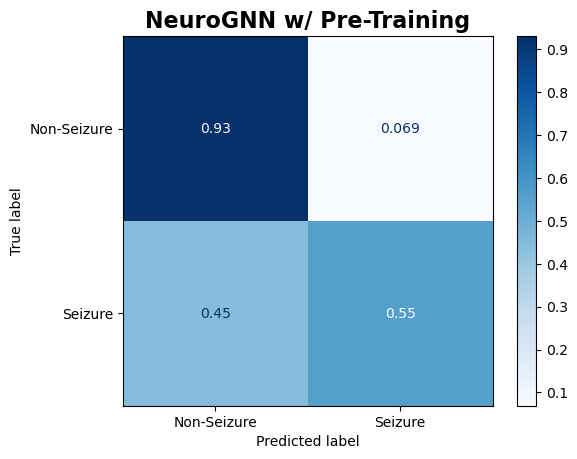

<Figure size 800x600 with 0 Axes>

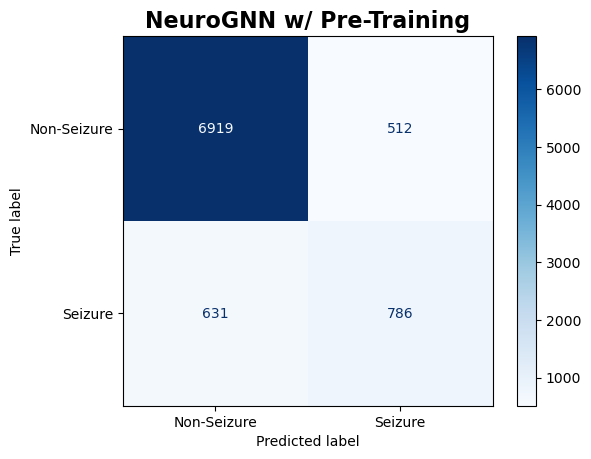

<Figure size 800x600 with 0 Axes>

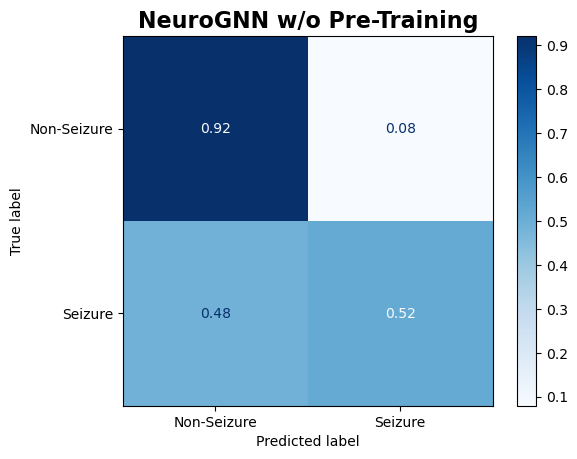

<Figure size 800x600 with 0 Axes>

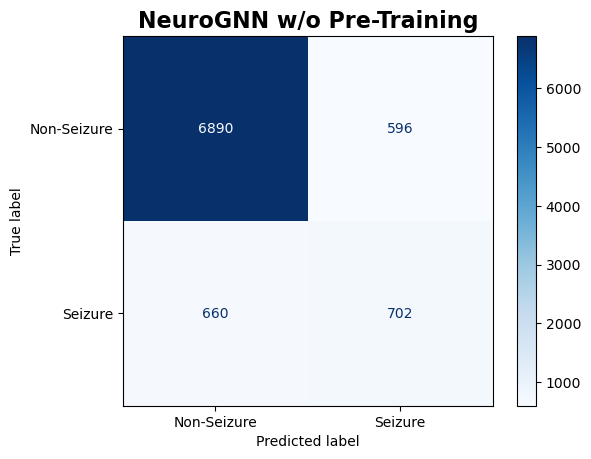

<Figure size 800x600 with 0 Axes>

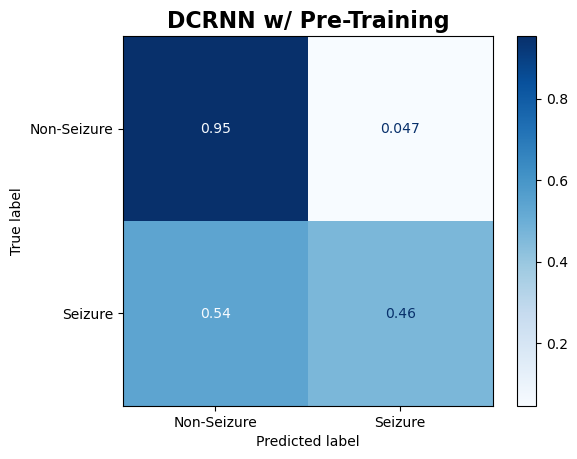

<Figure size 800x600 with 0 Axes>

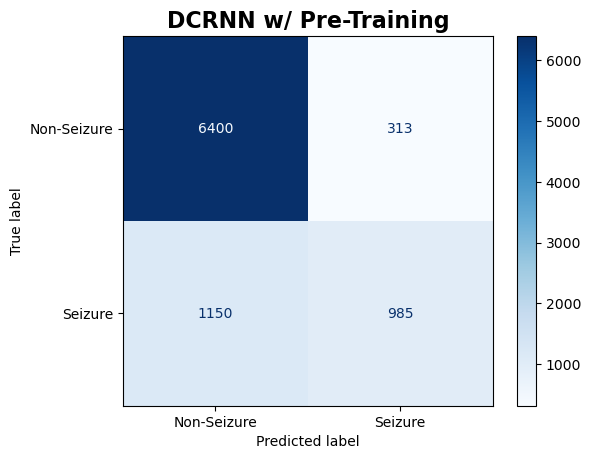

<Figure size 800x600 with 0 Axes>

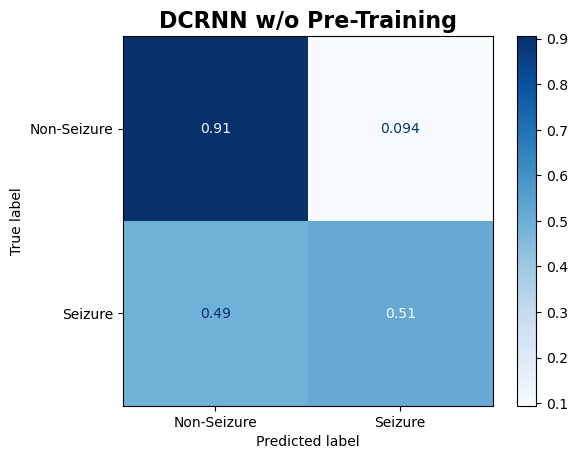

<Figure size 800x600 with 0 Axes>

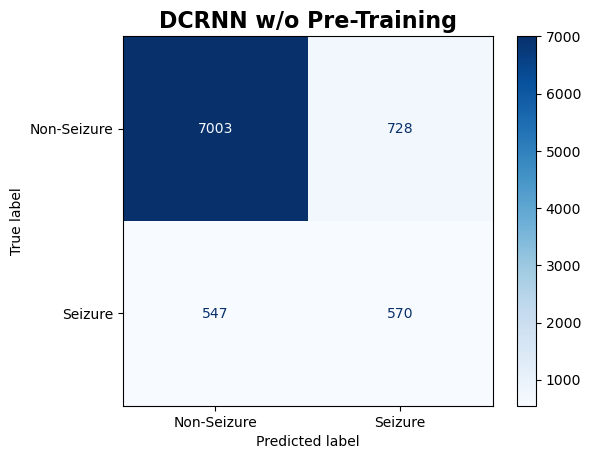

In [25]:
viz_confusion_mat(neurognn_det_pretrained_test_preds, neurognn_det_pretrained_test_labels, 'analysis/figures/detection/neurognn_det_pretrained_confusion_mat.png', title='NeuroGNN w/ Pre-Training')
viz_confusion_mat(neurognn_det_nopretrained_test_preds, neurognn_det_nopretrained_test_labels, 'analysis/figures/detection/neurognn_det_nopretrained_confusion_mat.png', title='NeuroGNN w/o Pre-Training')
viz_confusion_mat(dcrnn_det_pretrained_test_preds, dcrnn_det_pretrained_test_labels, 'analysis/figures/detection/dcrnn_det_pretrained_confusion_mat.png', title='DCRNN w/ Pre-Training')
viz_confusion_mat(dcrnn_det_nopretrained_test_preds, dcrnn_det_nopretrained_test_labels, 'analysis/figures/detection/dcrnn_det_nopretrained_confusion_mat.png', title='DCRNN w/o Pre-Training')

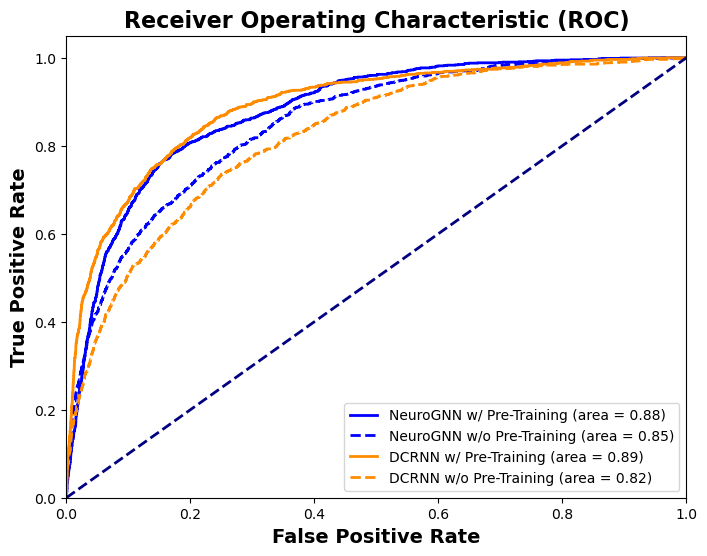

In [26]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
neurognn_pretrained_fpr, neurognn_pretrained_tpr, _ = roc_curve(neurognn_det_pretrained_test_labels, neurognn_det_pretrained_test_probs)
neurognn_nopretrained_fpr, neurognn_nopretrained_tpr, _ = roc_curve(neurognn_det_nopretrained_test_labels, neurognn_det_nopretrained_test_probs)
dcrnn_pretrained_fpr, dcrnn_pretrained_tpr, _ = roc_curve(dcrnn_det_pretrained_test_labels, dcrnn_det_pretrained_test_probs)
dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr, _ = roc_curve(dcrnn_det_nopretrained_test_labels, dcrnn_det_nopretrained_test_probs)

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
neurognn_pretrained_roc_auc = auc(neurognn_pretrained_fpr, neurognn_pretrained_tpr)
neurognn_nopretrained_roc_auc = auc(neurognn_nopretrained_fpr, neurognn_nopretrained_tpr)
dcrnn_pretrained_roc_auc = auc(dcrnn_pretrained_fpr, dcrnn_pretrained_tpr)
dcrnn_nopretrained_roc_auc = auc(dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(neurognn_pretrained_fpr, neurognn_pretrained_tpr, color='blue', lw=2, label='NeuroGNN w/ Pre-Training (area = %0.2f)' % neurognn_pretrained_roc_auc)
plt.plot(neurognn_nopretrained_fpr, neurognn_nopretrained_tpr, color='blue', linestyle='--', lw=2, label='NeuroGNN w/o Pre-Training (area = %0.2f)' % neurognn_nopretrained_roc_auc)
plt.plot(dcrnn_pretrained_fpr, dcrnn_pretrained_tpr, color='darkorange', lw=2, label='DCRNN w/ Pre-Training (area = %0.2f)' % dcrnn_pretrained_roc_auc)
plt.plot(dcrnn_nopretrained_fpr, dcrnn_nopretrained_tpr, linestyle='--', color='darkorange', lw=2, label='DCRNN w/o Pre-Training (area = %0.2f)' % dcrnn_nopretrained_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('analysis/figures/detection/auroc.png', dpi=300, bbox_inches='tight', transparent=True)

#### Classification Model

In [7]:
neurognn_classification_pretrained_model, neurognn_classification_pretrained_args = load_NeuroGNN_Classification(NEUROGNN_CLASSIFICATION_PRETRAINED_PATH)
neurognn_classification_nopretrained_model, neurognn_classification_nopretrained_args = load_NeuroGNN_Classification(NEUROGNN_CLASSIFICATION_NOPRETRAINED_PATH)

neurognn_classification_pretrained_test_results, neurognn_classification_pretrained_test_preds, \
    neurognn_classification_pretrained_test_labels, neurognn_classification_pretrained_test_probs, \
        neurognn_classification_pretrained_clips, neurognn_classificaiton_pretrained_files = eval_model(neurognn_classification_pretrained_model, 
                                                              dataloaders_classification_neurognn['test'],
                                                              neurognn_classification_pretrained_args,
                                                              )

neurognn_classification_nopretrained_test_results, neurognn_classification_nopretrained_test_preds, \
    neurognn_classification_nopretrained_test_labels, neurognn_classification_nopretrained_test_probs, \
        neurognn_classification_nopretrained_clips, neurognn_classification_nopretrained_files = eval_model(neurognn_classification_nopretrained_model,
                                                                dataloaders_classification_neurognn['test'],
                                                                neurognn_classification_nopretrained_args,
                                                                )


100%|██████████| 521/521 [00:01<00:00, 292.71it/s]


In [46]:

dcrnn_classification_pretrained_model, dcrnn_classification_pretrained_args = load_DCRNN_Classification(DCRNN_CLASSIFICATION_PRETRAINED_PATH)
dcrnn_classification_nopretrained_model, dcrnn_classification_nopretrained_args = load_DCRNN_Classification(DCRNN_CLASSIFICATION_NOPRETRAINED_PATH)

dcrnn_classification_pretrained_test_results, dcrnn_classification_pretrained_test_preds, \
    dcrnn_classification_pretrained_test_labels, dcrnn_classification_pretrained_test_probs, \
        dcrnn_classification_pretrained_clips, dcrnn_classificaiton_pretrained_files, \
            dcrnn_classification_pretrained_supports,  dcrnn_classification_pretrained_seq_lengths = eval_model(dcrnn_classification_pretrained_model,
                                                                dataloaders_classification_dcrnn['test'],
                                                                dcrnn_classification_pretrained_args,
                                                                )

dcrnn_classification_nopretrained_test_results, dcrnn_classification_nopretrained_test_preds, \
    dcrnn_classification_nopretrained_test_labels, dcrnn_classification_nopretrained_test_probs, \
        dcrnn_classification_nopretrained_clips, dcrnn_classification_nopretrained_files, \
             dcrnn_classification_nopretrained_supports, dcrnn_classification_nopretrained_seq_lengths = eval_model(dcrnn_classification_nopretrained_model,
                                                                dataloaders_classification_dcrnn['test'],
                                                                dcrnn_classification_nopretrained_args,
                                                                )

100%|██████████| 521/521 [00:01<00:00, 302.03it/s]


In [47]:
len(dcrnn_classification_pretrained_seq_lengths)

521

In [12]:

def viz_confusion_mat_classification(test_labels, test_preds, save_path=None, title='Seizure Classification Confusion Matrix'):
    for normalized in ['true', None]:
        conf_mat = confusion_matrix(test_labels, test_preds, normalize=normalized)
        # Visualize the confusion matrix
        class_names = ['CF', 'GN', 'AB', 'CT']  # Replace with your class names
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
        # Display the confusion matrix plot
        plt.figure(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(title, fontsize=16, fontweight='bold')
        # rotate x-axis labels
        plt.xticks(rotation=45, fontsize=12)
        # plt.show()
        if save_path:
            appendix = 'normalized' if normalized else 'unnormalized'
            plt.savefig(save_path[:-4]+appendix+'.png', dpi=300, bbox_inches='tight', transparent=True)

<Figure size 800x600 with 0 Axes>

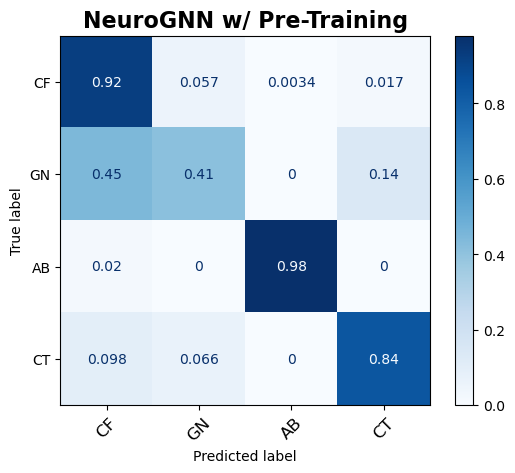

<Figure size 800x600 with 0 Axes>

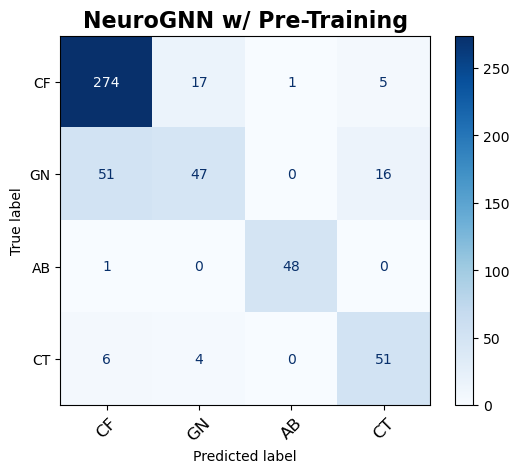

<Figure size 800x600 with 0 Axes>

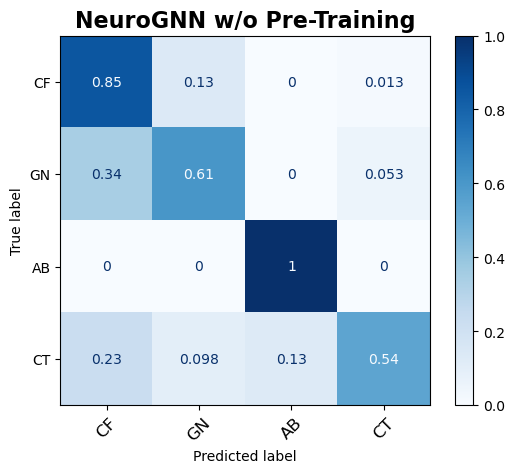

<Figure size 800x600 with 0 Axes>

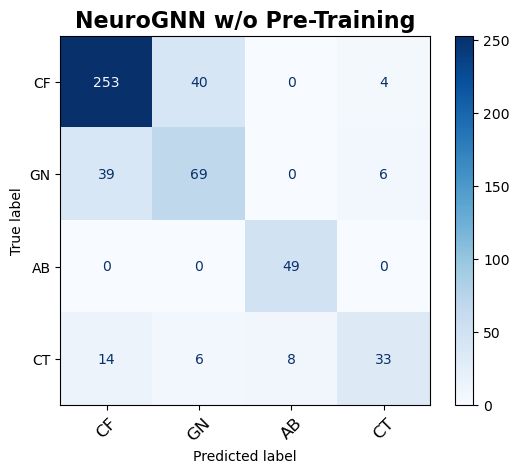

In [13]:
viz_confusion_mat_classification(neurognn_classification_pretrained_test_labels, neurognn_classification_pretrained_test_preds, title='NeuroGNN w/ Pre-Training', save_path='analysis/figures/classification/neurognn_pretrained_confusion_mat.png')
viz_confusion_mat_classification(neurognn_classification_nopretrained_test_labels, neurognn_classification_nopretrained_test_preds, title='NeuroGNN w/o Pre-Training', save_path='analysis/figures/classification/neurognn_nopretrained_confusion_mat.png')

## Interpretability

### Graph Embeddings

In [72]:
def get_seizure_sample(clips, labels, wanted_label, file_names=None):
    """
    Get a sample of seizure clips from the dataset.
    """
    seizure_clips = []
    target_files = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            seizure_clips.append(clips[i])
            if file_names:
                target_files.append(file_names[i])
    return torch.from_numpy(np.array(seizure_clips)), np.array(target_files)


def get_seizure_sample_dcrnn(clips, labels, wanted_label, supports, seq_lengths, file_names=None):
    """
    Get a sample of seizure clips from the dataset.
    """
    seizure_clips = []
    target_files = []
    target_supports = []
    target_seq_lengths = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            seizure_clips.append(clips[i])
            if file_names:
                target_files.append(file_names[i])
            if supports is not None:
                target_supports.append(supports[i])
            if seq_lengths is not None:
                target_seq_lengths.append(seq_lengths[i])
    return torch.from_numpy(np.array(seizure_clips)), np.array(target_files), torch.from_numpy(np.array(target_supports)), torch.from_numpy(np.array(target_seq_lengths))


def get_graph_embedding(model, clips, model_name='neurognn', batch_size=10, supports=None, seq_lengths=None):
    """
    Get graph embedding from NeuroGNN model using batch processing.
    """
    n = len(clips)
    all_embeddings = []

    # Turn off gradients for evaluation
    with torch.no_grad():
        for i in range(0, n, batch_size):
            # Create batch
            batch_clips = clips[i:i+batch_size]
            
            # Run through model
            if model_name == 'neurognn':
                node_embeds, _, _ = model.encoder(batch_clips)
                graph_embedding = model.relu(model.hierarchical_pooling(node_embeds, meta_node_indices=model.meta_node_indices))
            elif model_name == 'dcrnn':
                logits, node_embeddings = model(batch_clips, seq_lengths[i:i+batch_size], supports[i:i+batch_size])
                graph_embedding = np.max(node_embeddings.detach().clone().cpu(), axis=1)
            
            all_embeddings.append(graph_embedding)
    
    # Concatenate all embeddings
    all_embeddings = torch.cat(all_embeddings, dim=0)

    return all_embeddings

In [63]:
neurognn_cls_model = neurognn_classification_pretrained_model
neurognn_cls_model_args = neurognn_classification_pretrained_args
neurognn_cls_files = neurognn_classificaiton_pretrained_files
ab_clips, ab_files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 2, neurognn_cls_files)
ab_clips = ab_clips.to(neurognn_cls_model_args.device)

In [65]:
num_seizure_classes = 4
clips_all_classes = []
clips_all_classes_files = []
for i in range(num_seizure_classes):
    clips, files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, i, neurognn_cls_files)
    clips_all_classes.append(clips.to(neurognn_cls_model_args.device))
    clips_all_classes_files.append(files)

In [66]:
graph_embeddings_all_classes = []
for i in range(num_seizure_classes):
    graph_embeddings = get_graph_embedding(neurognn_cls_model, clips_all_classes[i])
    graph_embeddings_all_classes.append(graph_embeddings.detach().cpu().numpy())

##### T-SNE visualization for graph embeddings for 4 classes (NeuroGNN)

/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


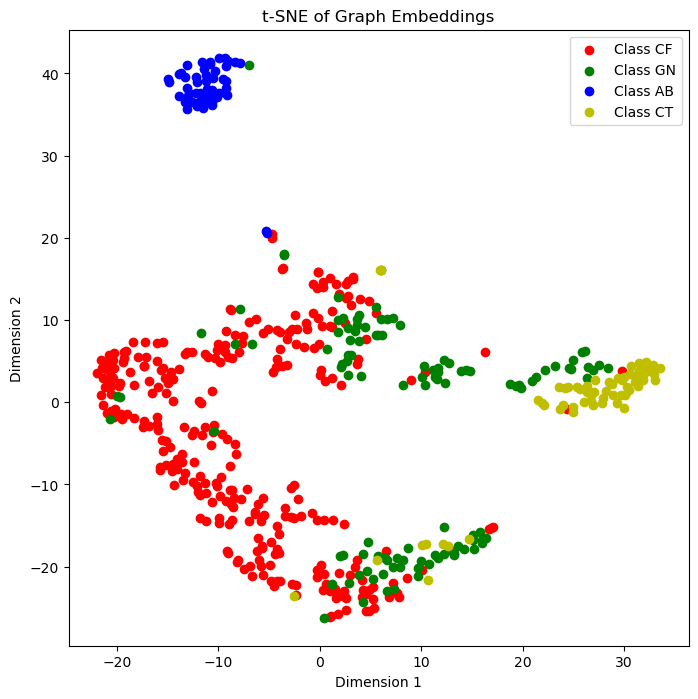

In [71]:
# Step 1: Combine all the embeddings and create a label vector
all_embeddings = np.concatenate(graph_embeddings_all_classes, axis=0)

class_labels = ['CF', 'GN', 'AB', 'CT']
labels = np.concatenate([
    np.full(len(graph_embeddings_all_classes[i]), class_labels[i])
    for i in range(len(graph_embeddings_all_classes))
])

# Step 2: Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(all_embeddings)

# Step 3: Scatter plot
plt.figure(figsize=(8, 8))

# Define colors (if you have more classes, add more colors)
colors = ['r', 'g', 'b', 'y']

for i, color in enumerate(colors):
    idx = labels == class_labels[i]
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], c=color, label=f'Class {class_labels[i]}')

plt.legend()
plt.title('t-SNE of Graph Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

##### UMAP Visualization of Graph Embeddings (NeuroGNN)

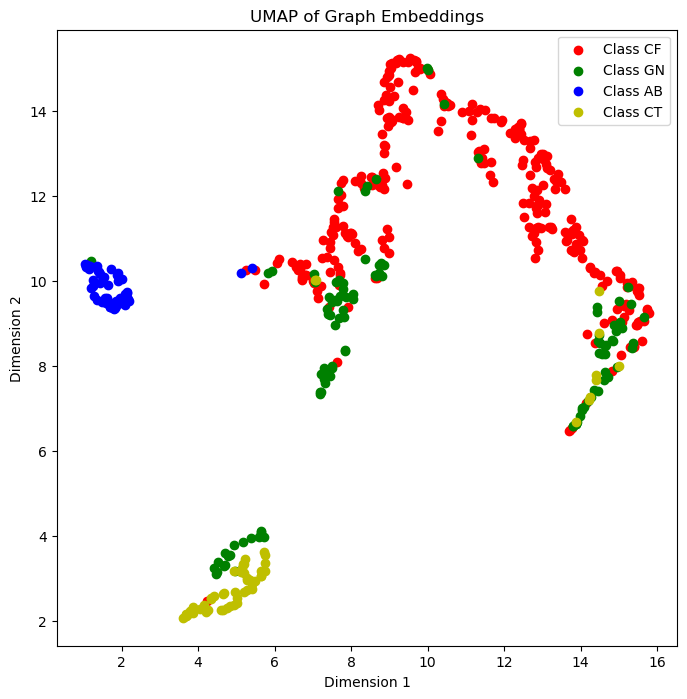

In [70]:
# Step 1: Combine all the embeddings and create a label vector
all_embeddings = np.concatenate(graph_embeddings_all_classes, axis=0)

class_labels = ['CF', 'GN', 'AB', 'CT']
labels = np.concatenate([
    np.full(len(graph_embeddings_all_classes[i]), class_labels[i])
    for i in range(len(graph_embeddings_all_classes))
])

# Step 2: Perform UMAP
reducer = umap.UMAP(random_state=42)
reduced_embeddings = reducer.fit_transform(all_embeddings)

# Step 3: Scatter plot
plt.figure(figsize=(8, 8))

# Define colors (if you have more classes, add more colors)
colors = ['r', 'g', 'b', 'y']

for i, color in enumerate(colors):
    idx = labels == class_labels[i]
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], c=color, label=f'Class {class_labels[i]}')

plt.legend()
plt.title('UMAP of Graph Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

##### TSNE Graph Embeddings (DCRNN)

In [67]:
dcrnn_cls_model = dcrnn_classification_pretrained_model
dcrnn_cls_model_args = dcrnn_classification_pretrained_args
dcrnn_cls_files = dcrnn_classificaiton_pretrained_files
dcrnn_supports = dcrnn_classification_pretrained_supports
dcrnn_seq_lengths = dcrnn_classification_pretrained_seq_lengths

In [68]:
num_seizure_classes = 4
clips_all_classes = []
clips_all_classes_files = []
supports_all_classes = []
seq_lengths_all_classes = []
for i in range(num_seizure_classes):
    clips, files, supports, seq_lengths = get_seizure_sample_dcrnn(dcrnn_classification_pretrained_clips, dcrnn_classification_pretrained_test_labels, i, dcrnn_supports, dcrnn_seq_lengths, dcrnn_cls_files)
    clips_all_classes.append(clips.to(dcrnn_cls_model_args.device))
    clips_all_classes_files.append(files)
    supports_all_classes.append(supports.to(dcrnn_cls_model_args.device))
    seq_lengths_all_classes.append(seq_lengths.to(dcrnn_cls_model_args.device))

In [76]:
graph_embeddings_all_classes = []
for i in range(num_seizure_classes):
    graph_embeddings = get_graph_embedding(dcrnn_cls_model, clips_all_classes[i], model_name='dcrnn', supports=supports_all_classes[i], seq_lengths=seq_lengths_all_classes[i])
    graph_embeddings_all_classes.append(graph_embeddings.detach().cpu().numpy())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (190x3444 and 492x128)

#### How about unseen classes?

In [82]:
get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 3, neurognn_cls_files)

(tensor([[[[ 2.4827e+00,  2.5238e-01,  2.3289e+00,  ..., -4.7533e-01,
            -7.7456e-01, -9.0519e-01],
           [ 2.4483e+00,  1.5151e+00,  2.2915e+00,  ..., -6.2444e-01,
            -8.4022e-01, -8.8023e-01],
           [ 2.2810e+00,  1.0924e+00,  2.3643e+00,  ..., -4.0740e-01,
            -5.0469e-01, -7.8149e-01],
           ...,
           [ 1.9052e+00,  1.9087e+00,  2.3244e+00,  ..., -4.2048e-01,
            -8.6138e-01, -7.0300e-01],
           [ 1.6794e+00,  2.2479e+00,  2.4270e+00,  ..., -3.9204e-01,
            -6.9762e-01, -7.9479e-01],
           [ 2.1976e+00,  1.6664e+00,  2.3461e+00,  ..., -5.1474e-01,
            -7.0693e-01, -8.4539e-01]],
 
          [[ 3.5364e+00,  2.8788e+00,  2.3081e+00,  ..., -1.2110e+00,
            -5.6539e-01, -7.1330e-01],
           [ 3.4845e+00,  2.8619e+00,  2.3120e+00,  ..., -1.0154e+00,
            -9.0065e-01, -9.3673e-01],
           [ 3.5958e+00,  2.8890e+00,  2.4381e+00,  ..., -1.1275e+00,
            -9.5084e-01, -8.6134e-01],


### Node embeddings during seizures

In [12]:
def get_seizure_sample(clips, labels, wanted_label, file_names=None):
    """
    Get a sample of seizure clips from the dataset.
    """
    seizure_clips = []
    target_files = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            seizure_clips.append(clips[i])
        if file_names:
            target_files.append(file_names[i])
    return torch.from_numpy(np.array(seizure_clips)), np.array(target_files)

def get_normal_sample(clips, labels, wanted_label=0):
    """
    Get a sample of normal clips from the dataset.
    """
    normal_clips = []
    for i in range(len(clips)):
        if labels[i] == wanted_label:
            normal_clips.append(clips[i])
    return torch.from_numpy(np.array(normal_clips))

In [13]:
neurognn_cls_model = neurognn_classification_pretrained_model
neurognn_cls_model_args = neurognn_classification_pretrained_args
neurognn_cls_files = neurognn_classificaiton_pretrained_files
ab_clips, ab_files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 2, neurognn_cls_files)
ab_clips = ab_clips.to(neurognn_cls_model_args.device)
focal_clips, focal_files = get_seizure_sample(neurognn_classification_pretrained_clips, neurognn_classification_pretrained_test_labels, 0, neurognn_cls_files)
focal_clips = focal_clips.to(neurognn_cls_model_args.device)

In [14]:
neurognn_det_model = neurognn_det_pretrained
neurognn_det_model_args = neurognn_det_pretrained_args
normal_clips = get_normal_sample(neurognn_det_pretrained_clips, neurognn_det_pretrained_test_labels)
normal_clips = normal_clips.to(neurognn_det_model_args.device)

In [15]:
neurognn_cls_model(ab_clips).softmax(dim=1).argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2], device='cuda:0')

In [16]:
neurognn_cls_model.encoder(ab_clips)[0].shape ### YAY! Got the node embeddings!

torch.Size([49, 25, 256])

In [17]:
neurognn_cls_model(focal_clips[0:5]).softmax(dim=1).argmax(dim=1)

tensor([0, 0, 0, 1, 0], device='cuda:0')

In [18]:
print(neurognn_det_model(normal_clips[0:5]))

tensor([[ 0.1817],
        [-0.3920],
        [-3.1166],
        [-1.6694],
        [-0.2985]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [19]:
ab_files

array(['00009578_s011_t008.edf_0', '00008512_s007_t001.edf_0',
       '00009866_s003_t006.edf_6', '00008544_s006_t005.edf_0',
       '00008453_s007_t005.edf_0', '00010022_s003_t001.edf_1',
       '00008544_s005_t001.edf_0', '00009570_s001_t000.edf_1',
       '00000675_s002_t001.edf_3', '00002297_s003_t000.edf_0',
       '00009578_s005_t000.edf_0', '00001984_s001_t001.edf_1',
       '00010062_s008_t001.edf_1', '00001984_s001_t001.edf_2',
       '00009839_s005_t021.edf_0', '00005479_s004_t000.edf_0',
       '00008544_s002_t004.edf_0', '00008889_s004_t007.edf_2',
       '00010062_s004_t002.edf_1', '00008479_s002_t006.edf_0',
       '00009839_s005_t019.edf_0', '00010062_s006_t000.edf_0',
       '00008544_s004_t006.edf_0', '00000675_s002_t001.edf_12',
       '00000675_s002_t001.edf_1', '00009697_s003_t004.edf_0',
       '00008889_s004_t015.edf_1', '00000675_s001_t001.edf_2',
       '00009866_s003_t007.edf_0', '00009866_s003_t007.edf_5',
       '00008889_s004_t011.edf_0', '00009578_s029_t001

In [92]:
### During absence seizure, frontal lobe is more active, can our model find that?
node_embeddings_normal = neurognn_det_model.encoder(normal_clips[:5])[0][0].detach().cpu().numpy()
node_embeddings_abs = neurognn_cls_model.encoder(ab_clips[1:2])[0][0].detach().cpu().numpy()
node_embeddings_focal = neurognn_cls_model.encoder(focal_clips[:5])[0][0].detach().cpu().numpy()

adj_mat_abs = neurognn_cls_model.encoder(ab_clips[1:2])[1].detach().cpu().numpy()

In [169]:
def viz_embeddings(node_embeddings, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

    reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(node_embeddings)
    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])

    
    df_umap['node_label'] = pd.Series(INCLUDED_CHANNELS + CORTEX_REGIONS)
    node_regions = []
    for node_label in df_umap['node_label']:
        if node_label in ELECTRODES_REGIONS:
            node_regions.append(ELECTRODES_REGIONS[node_label])
        else:
            node_regions.append(node_label)
    df_umap['node_region'] = node_regions

    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', ax=ax, hue='node_region', s=100)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    # annotate node labels
    for i, label in enumerate(df_umap['node_label']):
        ax.annotate(label, (embeddings_umap[i, 0], embeddings_umap[i, 1]), fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    
    
def viz_adj_mat(adj_mat, save_path=None):
    df = pd.DataFrame()
    df['node_label'] = pd.Series(INCLUDED_CHANNELS + CORTEX_REGIONS)
    node_regions = []
    for node_label in df['node_label']:
        if node_label in ELECTRODES_REGIONS:
            node_regions.append(ELECTRODES_REGIONS[node_label])
        else:
            node_regions.append(node_label)
    df['node_region'] = node_regions

    sns.heatmap(adj_mat, cmap='Blues', xticklabels=df['node_label'], yticklabels=df['node_label'])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)



In [93]:
adj_mat_abs.sum(axis=1)

array([0.5133403 , 0.5120508 , 0.5060954 , 0.50435275, 0.4921673 ,
       0.4921673 , 0.5080638 , 0.49991608, 0.5062382 , 0.50374365,
       0.49922612, 0.4996528 , 0.49373168, 0.49828285, 0.49375764,
       0.49441016, 0.5063859 , 0.4795101 , 0.5058126 , 0.48430896,
       0.49266818, 0.5004463 , 0.5074291 , 0.49304467, 0.46925366],
      dtype=float32)

In [106]:
adj_mat_abs

array([[0.04000005, 0.02370288, 0.02364541, 0.01960839, 0.01870815,
        0.01870816, 0.01910088, 0.01861527, 0.01792308, 0.01778441,
        0.02289783, 0.0188489 , 0.01892294, 0.01902681, 0.01808496,
        0.01812779, 0.02009085, 0.01762188, 0.01819671, 0.03225443,
        0.0197111 , 0.01864867, 0.01854673, 0.01687773, 0.01768625],
       [0.02370293, 0.03999998, 0.01961122, 0.02365437, 0.01865721,
        0.01865722, 0.0189823 , 0.01843022, 0.01787983, 0.01776766,
        0.01870127, 0.0227235 , 0.01882862, 0.01894978, 0.01805882,
        0.01809402, 0.02002823, 0.01769619, 0.01821771, 0.03212916,
        0.01975922, 0.01858599, 0.01840582, 0.01676864, 0.01776089],
       [0.02364544, 0.01961122, 0.04      , 0.01966737, 0.02100529,
        0.01875252, 0.01918493, 0.01867191, 0.01806024, 0.01793323,
        0.02401389, 0.01881797, 0.01890672, 0.01903322, 0.01824123,
        0.01827777, 0.02351494, 0.01771299, 0.01827159, 0.01976649,
        0.02084344, 0.01874531, 0.01854942, 0.

In [164]:
node_label_index_mapping = {key: value for key, value in zip(range(26), INCLUDED_CHANNELS + CORTEX_REGIONS)}
node_label_index_mapping_inverse = {value: key for key, value in node_label_index_mapping.items()}

In [165]:
# index of top 5 highest values
high_ns_c3 = adj_mat_abs[node_label_index_mapping_inverse['EEG C3']].argsort()[::-1]
high_ns_c4 = adj_mat_abs[node_label_index_mapping_inverse['EEG C4']].argsort()[::-1]
print(f'highest correlations for C3: {[node_label_index_mapping[n] for n in high_ns_c3]}')
print(f'highest correlations for C4: {[node_label_index_mapping[n] for n in high_ns_c4]}')

highest correlations for C3: ['EEG C3', 'Parietal Lobe', 'EEG F3', 'EEG T3', 'EEG P3', 'EEG C4', 'EEG CZ', 'EEG T4', 'EEG FZ', 'EEG F7', 'EEG F8', 'EEG F4', 'Frontal Lobe', 'EEG FP1', 'EEG FP2', 'Central Gyrus', 'Temporal Lobe', 'EEG P4', 'EEG PZ', 'Pre-Frontal Lobe', 'EEG T6', 'EEG T5', 'EEG O1', 'EEG O2', 'Occipital Lobe']
highest correlations for C4: ['EEG C4', 'Parietal Lobe', 'EEG F4', 'EEG T4', 'EEG P4', 'EEG C3', 'EEG CZ', 'EEG T3', 'EEG FZ', 'EEG F7', 'EEG F8', 'EEG F3', 'Frontal Lobe', 'EEG FP1', 'EEG FP2', 'EEG P3', 'Central Gyrus', 'Temporal Lobe', 'EEG PZ', 'Pre-Frontal Lobe', 'EEG T6', 'EEG T5', 'EEG O1', 'EEG O2', 'Occipital Lobe']


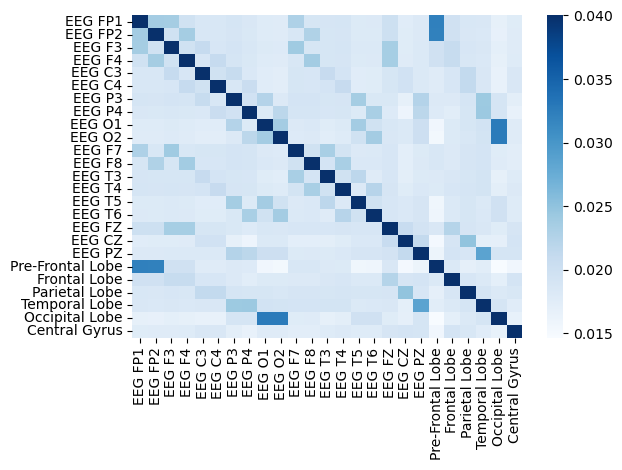

In [171]:
viz_adj_mat(adj_mat_abs, save_path='analysis/figures/interpretability/adj_mat_seizure_class_absence(ab).png')

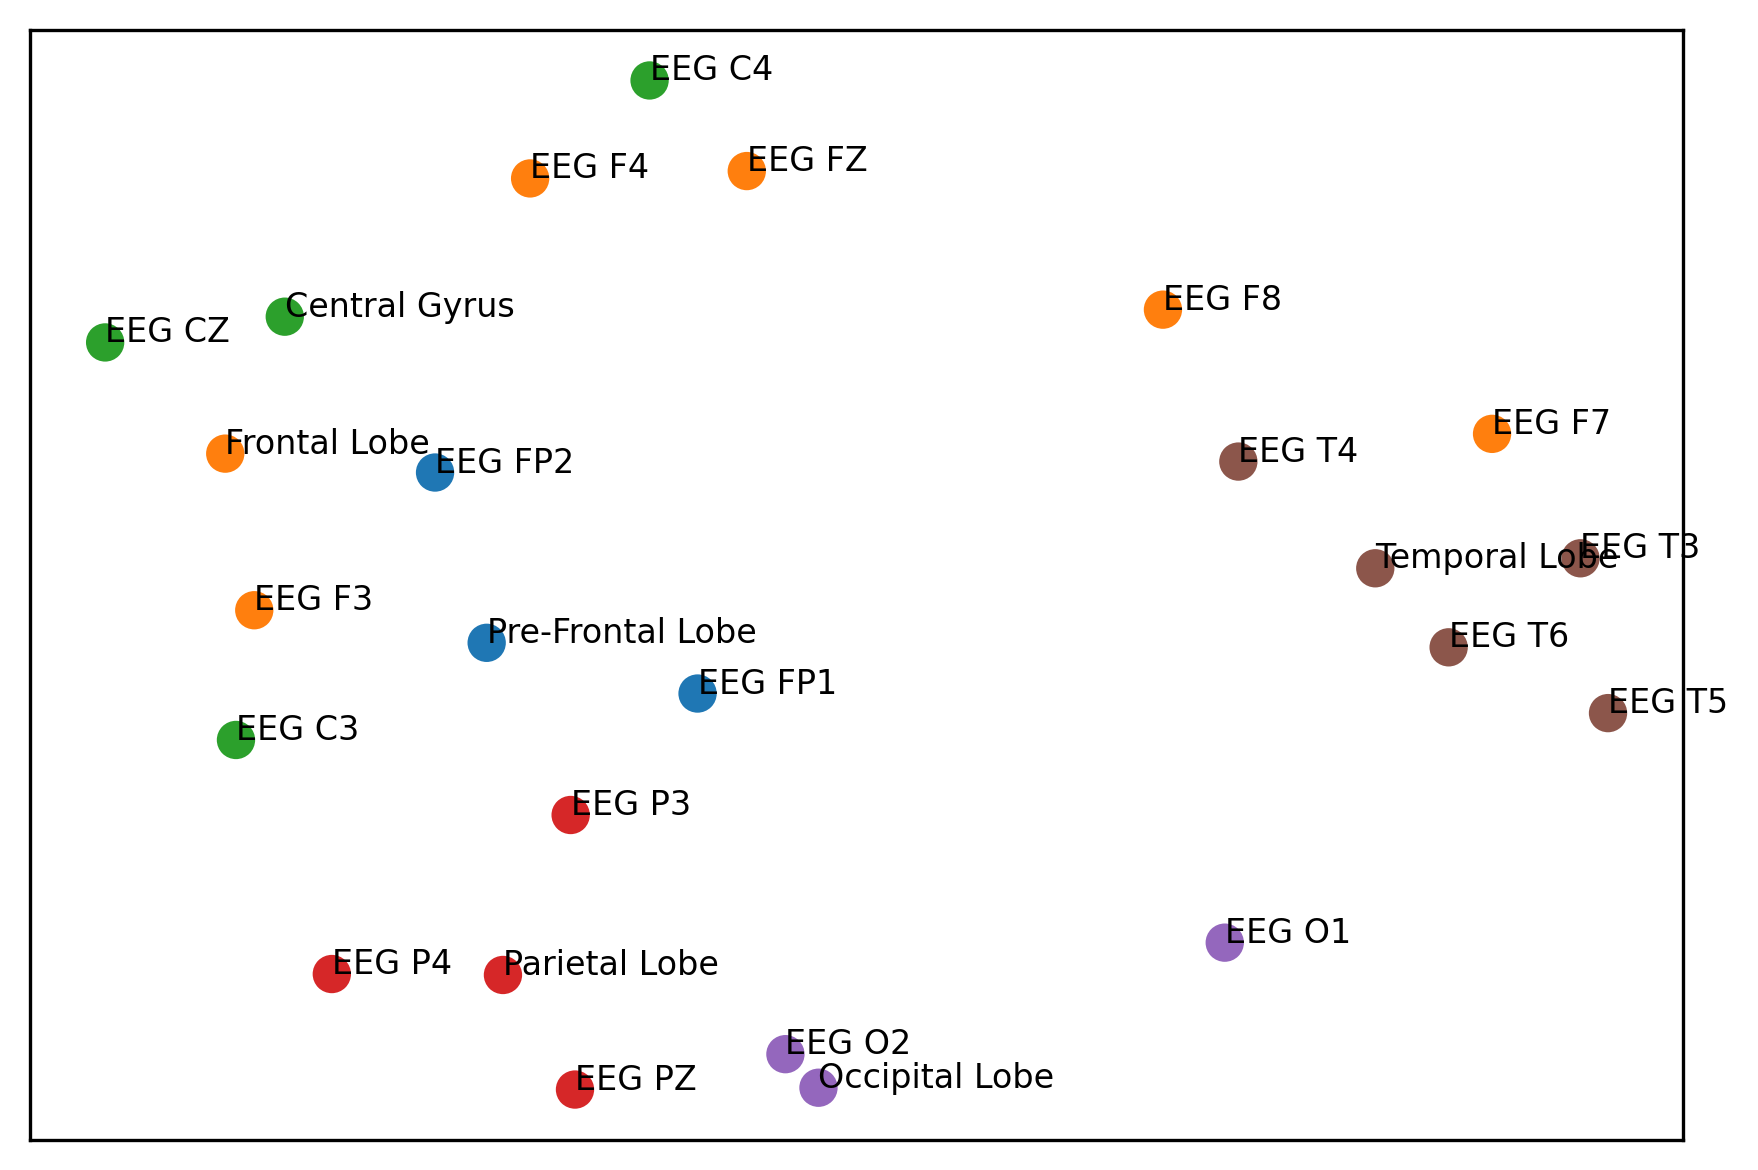

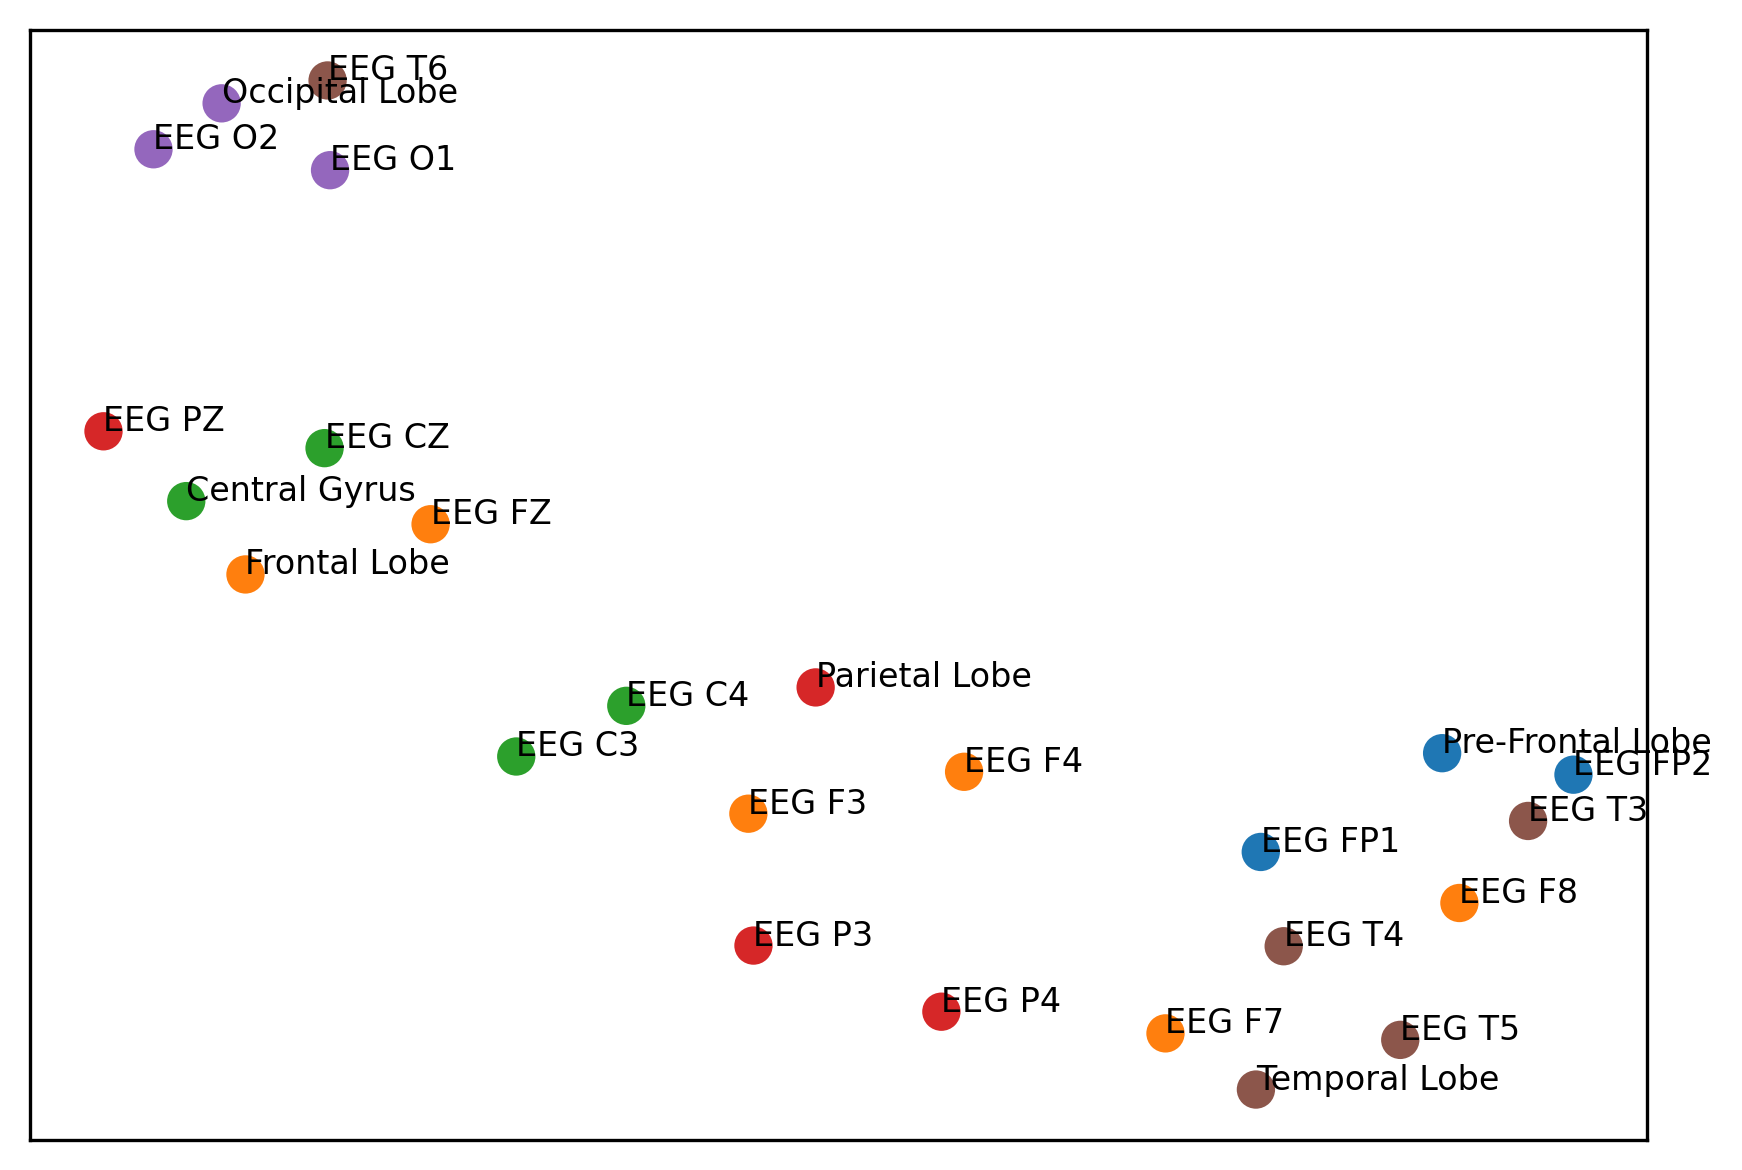

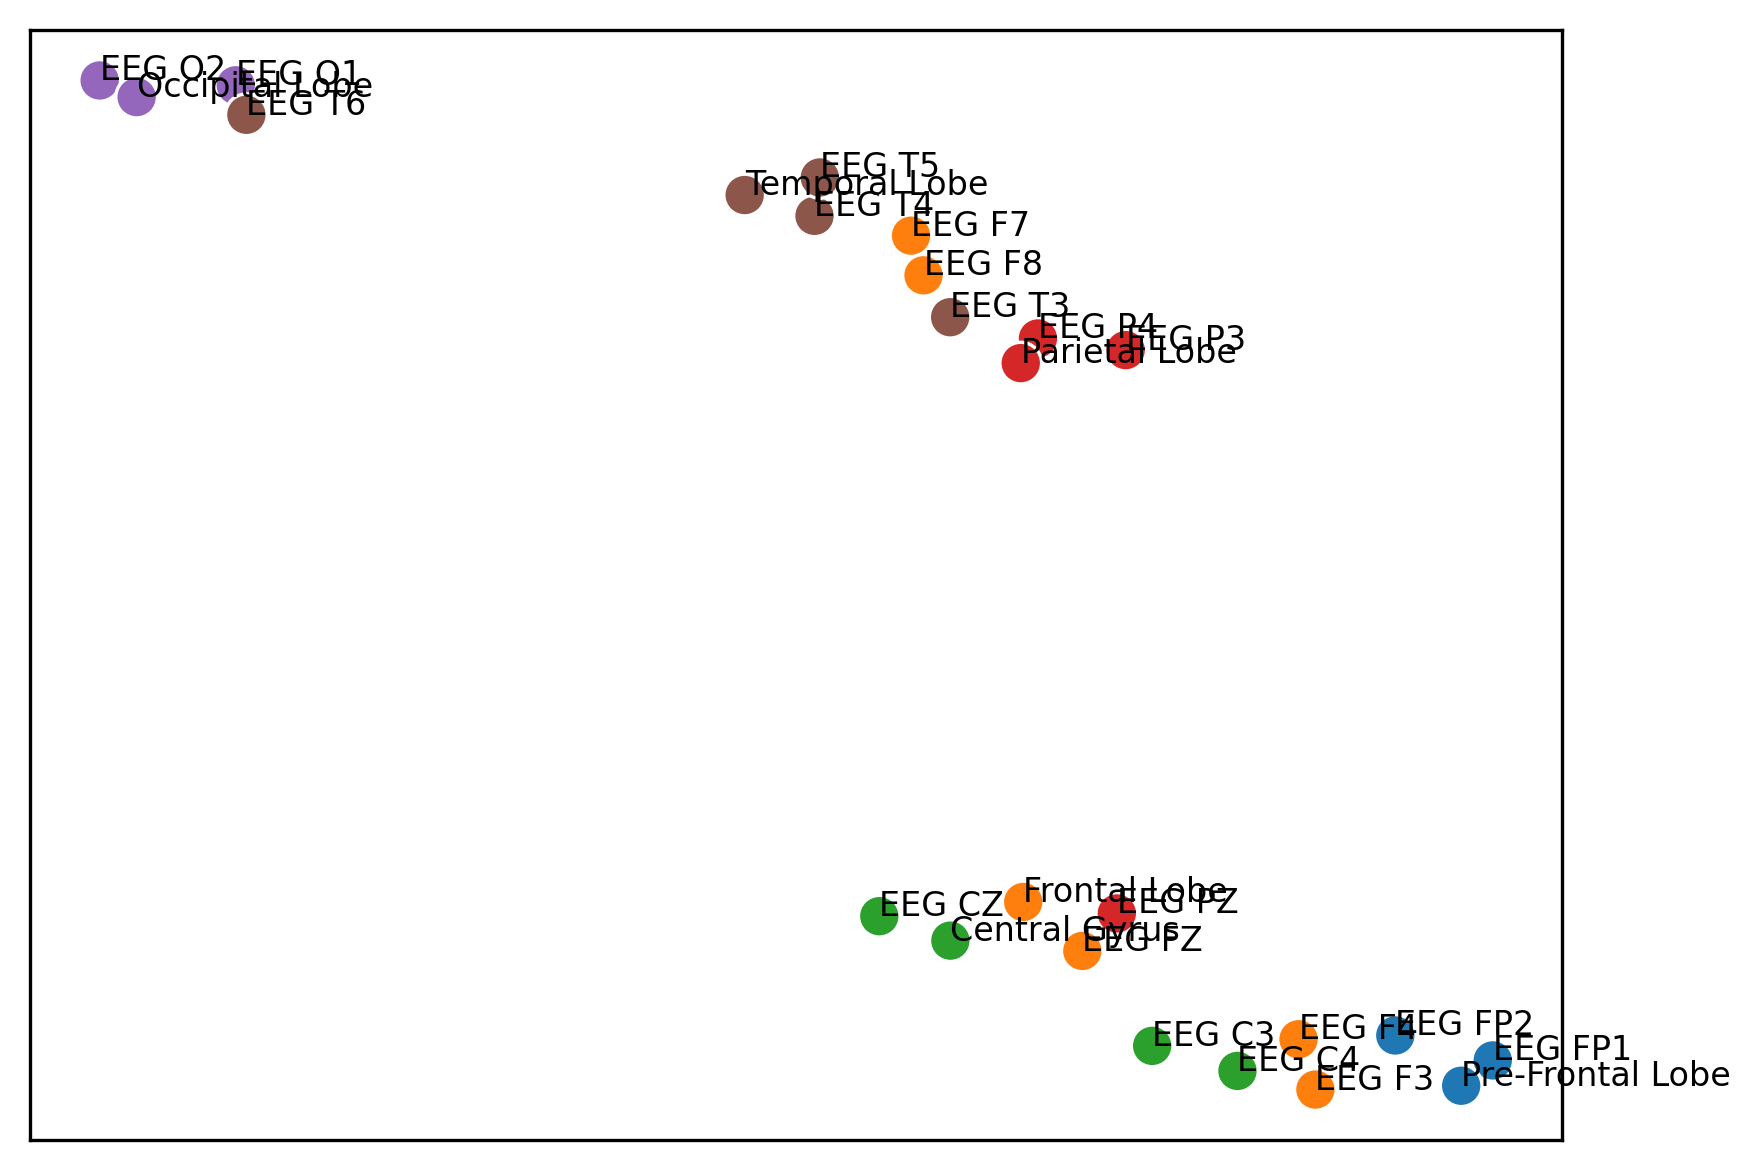

In [172]:
viz_embeddings(node_embeddings_normal)
viz_embeddings(node_embeddings_abs, save_path='analysis/figures/interpretability/embeddings_seizure_class_absence(abs).png') # repetitive seizures in left hemisphere
viz_embeddings(node_embeddings_focal)

In [145]:
    """
    abs: second figure
    CLINICAL HISTORY:  61 year old gentleman with stroke, left MCA infarct, recurrent status epilepticus, cardiac arrest due January 22, 2012 for 9 minutes, followed by right gaze deviation with left hand shaking.  Evaluate for recurrent seizures.  Persistent obtundation.
MEDICATIONS:  Dilantin, Lamictal, Dopamine, Dobutamine, Keppra.
INTRODUCTION:  Digital video EEG was performed at bedside using standard 10-20 system of electrode placement.  The patient is poorly responsive and has a tracheostomy.
DESCRIPTION OF THE RECORD:  The background EEG is markedly abnormal.  Multiple electrographic seizures are noted with high amplitude epileptiform activity from the left hemisphere, typically maximum in the left frontal central region, but with a generous field of spread.
The spikes seems to be maximum at C3, but fast activity is seen throughout the left frontal central region with more periodic activity left frontal.  In some locations there seems to be a posterior to anterior lag or even more than one epileptiform focus in the left temporal region, but the ictal driver seems to be in the left frontal central region.
Seizures are typically on the duration of 1-2 minutes.  Characteristic frequency of evolution of the seizures was observed.
Despite the marked background slowing, the patient seems to be somewhat responsive.  During the seizures, he has head turning to the right, but not really a forced deviation, more of a more gentle head turning.
When he is not seizing, he does seem to demonstrate some head control and some spontaneous movement on the left when the seizures stop.
The background EEG is otherwise markedly slow bilaterally.
HR:    120 bpm
IMPRESSION:  Abnormal EEG due to:
A status epilepticus pattern with multiple, repetitive seizures from the left hemisphere.
Sharp waves and spikes in the left.
Intermittent burst suppressed pattern when the patient is not seizing.
Some generalized periodic complexes observed in the interictal section of the record.
Some posterior predominant generalized periodic discharges also noted in the interictal period.
CLINICAL CORRELATION:  This patient has previously been evaluated for status epilepticus out of the left hemisphere.  This EEG may demonstrate some features which are due to anoxic encephalopathy, as well as the ictal pattern.

    """

'\nabs: second figure\nCLINICAL HISTORY:  61 year old gentleman with stroke, left MCA infarct, recurrent status epilepticus, cardiac arrest due January 22, 2012 for 9 minutes, followed by right gaze deviation with left hand shaking.  Evaluate for recurrent seizures.  Persistent obtundation.\nMEDICATIONS:  Dilantin, Lamictal, Dopamine, Dobutamine, Keppra.\nINTRODUCTION:  Digital video EEG was performed at bedside using standard 10-20 system of electrode placement.  The patient is poorly responsive and has a tracheostomy.\nDESCRIPTION OF THE RECORD:  The background EEG is markedly abnormal.  Multiple electrographic seizures are noted with high amplitude epileptiform activity from the left hemisphere, typically maximum in the left frontal central region, but with a generous field of spread.\nThe spikes seems to be maximum at C3, but fast activity is seen throughout the left frontal central region with more periodic activity left frontal.  In some locations there seems to be a posterior to